# Create a RNN model to text generation
- RNN model at character level
    - Input: n character previous
    - Output: next character
    - Model LSTM
- Use 'El Quijote' to train the generator


In [1]:
# Header
from __future__ import print_function

import numpy as np
import keras
print('Keras version: ', keras.__version__)

# GPU devices visible by python
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Limit memory usage
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


path = '/home/ubuntu/data/training/keras/'

Using TensorFlow backend.


Keras version:  2.0.1


## Download data and generate sequences

Download quijote from guttenberg project

wget http://www.gutenberg.org/cache/epub/2000/pg2000.txt

In [5]:
#Read book
text = open(path + "pg2000.txt").read().lower()
print('corpus length:', len(text))

# Simplify text to improve the semantic capacities of the model.
delete_chars = [ '"', '#', '$', '%', "'", '(', ')', '*', '-', '/', '0', '1', '2', '3', '4', '5', '6',
                '7', '8', '9', '@', '[', ']', '«', '»', 'à', 'ï', 'ù', '\ufeff']
for ch in delete_chars:
    text=text.replace(ch,"")

print('corpus length deleted:', len(text))

chars = sorted(list(set(text)))
print('Chars list: ', chars)
print('total chars:', len(chars))

#Dictionaries to convert char to num & num to char
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


corpus length: 2117498
corpus length deleted: 2108713
Chars list:  ['\n', ' ', '!', ',', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '¿', 'á', 'é', 'í', 'ñ', 'ó', 'ú', 'ü']
total chars: 43


In [3]:
# cut the text in semi-redundant sequences of maxlen characters
# One sentence of length 20 for each 3 characters
maxlen = 20
step = 3
sentences = []
next_chars = []
for i in range(3000, len(text) - maxlen, step): #Start in character 3000 to exclude Gutenberg header.
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))
print(sentences[4996], '-', next_chars[4996])

nb sequences: 701898
s de
santos, sino pr - o


## Train the model

In [4]:
'''
X: One row by sentence
    in each row a matrix of bool 0/1 of dim length_sentence x num_chars coding the sentence. Dummy variables
y: One row by sentence
    in each row a vector of bool of lengt num_chars with 1 in the next char position
'''

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

print('X shape: ',X.shape)
print('y shape: ',y.shape)

Vectorization...
X shape:  (701898, 20, 43)
y shape:  (701898, 43)


In [5]:
# build the model: 2 stacked LSTM
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM
from keras import optimizers

print('Build model 1')
seq_prev_input = Input(shape=(maxlen, len(chars)), name='prev') 
                
# apply forwards LSTM
forwards1 = LSTM(1024, return_sequences=True,  dropout=0.3, recurrent_dropout=0.3)(seq_prev_input)

forwards2 = LSTM(1024, return_sequences=True,  dropout=0.3, recurrent_dropout=0.3)(forwards1)

forwards3 = LSTM(1024, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)(forwards2)

output = Dense(len(chars), activation='softmax')(forwards3)

model = Model(inputs=seq_prev_input, outputs=output)
model.summary()

# try using different optimizers and different optimizer configs
Nadam = optimizers.Nadam(lr=0.0002, schedule_decay=0.000025)
model.compile(loss='categorical_crossentropy', optimizer=Nadam, metrics=['accuracy'])


Build model 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prev (InputLayer)            (None, 20, 43)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 1024)          4374528   
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 1024)          8392704   
_________________________________________________________________
lstm_3 (LSTM)                (None, 1024)              8392704   
_________________________________________________________________
dense_1 (Dense)              (None, 43)                44075     
Total params: 21,204,011.0
Trainable params: 21,204,011.0
Non-trainable params: 0.0
_________________________________________________________________


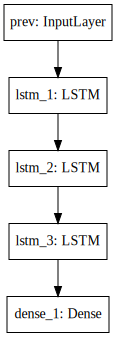

In [6]:
#Plot the model graph
from IPython.display import SVG
from keras.utils import vis_utils

SVG(vis_utils.model_to_dot(model).create(prog='dot', format='svg'))

In [7]:
#Fit model
history = model.fit(X[:600000], y[:600000], batch_size=256, epochs=12,
           validation_data=(X[600000:], y[600000:]))



Train on 600000 samples, validate on 101898 samples
Epoch 1/12
600000/600000 [==============================] - 498s - loss: 2.4591 - acc: 0.2761 - val_loss: 2.0847 - val_acc: 0.3696
Epoch 2/12
600000/600000 [==============================] - 502s - loss: 1.8640 - acc: 0.4239 - val_loss: 1.7899 - val_acc: 0.4668
Epoch 3/12
600000/600000 [==============================] - 500s - loss: 1.6327 - acc: 0.4928 - val_loss: 1.6655 - val_acc: 0.5043
Epoch 4/12
600000/600000 [==============================] - 498s - loss: 1.5090 - acc: 0.5279 - val_loss: 1.5971 - val_acc: 0.5277
Epoch 5/12
600000/600000 [==============================] - 502s - loss: 1.4298 - acc: 0.5502 - val_loss: 1.5617 - val_acc: 0.5406
Epoch 6/12
600000/600000 [==============================] - 499s - loss: 1.3731 - acc: 0.5663 - val_loss: 1.5364 - val_acc: 0.5490
Epoch 7/12
600000/600000 [==============================] - 503s - loss: 1.3293 - acc: 0.5780 - val_loss: 1.5153 - val_acc: 0.5558
Epoch 8/12
600000/600000 [=====

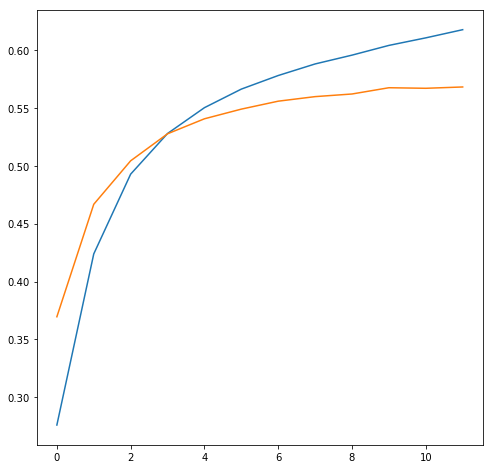

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [9]:
from keras.models import save_model

save_model(model, path + 'models/text_generation_model1024.h5')


## Evaluate model

In [2]:
from keras.models import load_model

model1 = load_model(path + 'models/text_generation_model1024.h5')


In [3]:
maxlen = 20


def sample(a, diversity=1.0):
    '''
    helper function to sample an index from a probability array
    - Diversity control the level of randomless
    '''
    a = np.log(a) / diversity
    a = np.exp(a) / np.sum(np.exp(a), axis=0)
    a /= np.sum(a+0.0000001) #Precission error
    return np.argmax(np.random.multinomial(1, a, 1))


def generate_text(sentence, diversity, current_model, num_char=400):
    sentence_init = sentence
    generated = ''
    for i in range(400):
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_indices[char]] = 1.
        preds = current_model.predict(x, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
    print()
    print('DIVERSITY: ',diversity)
    print(sentence_init + generated)


In [6]:
sentence = 'mire vuestra merced '
generate_text(sentence, 0.2, model1)


DIVERSITY:  0.2
mire vuestra merced le había de ser todo el mundo, y así, le dijo:

señor respondió el del bosque, que no te hago salido de los señores que le diesen la mano y en el mundo que se le había de dar la mano, y que no te hago saber que el señor don quijote, que se le había de ser menester el barbero y de los caballeros andantes caballeros andantes que la había de ser con la mano y de la triste figura de la mancha, pero no


In [14]:

sentence = 'mire vuestra merced '
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)


sentence = 'a mi señora dulcinea'
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)


sentence = 'el caballero andante'
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)



DIVERSITY:  0.2
mire vuestra merced le había de ser todo el cuerpo, por medio de la mano, y de la cabeza y la primera parte de la mano, y que no se pone en la cabeza, y aun se le había de ser el mundo, y aun a las manos de la caballería que le había de ser todo lo que se le había de hacer noticia del toboso, y de la cabeza y de manera que el alma a su padre, y aun a su padre la duquesa, que no poco se pone en la memoria la cabeza, y

DIVERSITY:  0.5
mire vuestra merced que los que se le había de decir alguna cosa que a todos los sonetos, porque no ha de ser el mayordomo, y así, se lo dijese a esta sazón don quijote.

pues es verdad que no se pone en la mitad del camino a la cabeza y todo con ellos que se llamaba de tener grandes espaciosos y con ellos, y de la venta a la leyes, y con las antiguas de las que don quijote, es posible que la hermosa morir en casa, d

DIVERSITY:  1
mire vuestra merced ha más poco mentira de lo que tan verdaderamente de su madre, que de lo que yo
pisiómble 